In [1]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.circuit.library import CXGate
from qiskit.dagcircuit import DAGOpNode
from qiskit.converters import circuit_to_dag, dag_to_circuit

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import copy
import math
from sklearn.cluster import KMeans

In [2]:
def grayvalue_to_angle(value):
    return (value/255) * pi/2

def grayscale_to_angles(image_mat):
    for i in range(len(image_mat)):
        for j in range(len(image_mat)):
            image_mat[i][j] = grayvalue_to_angle(image_mat[i][j])
    
    return image_mat

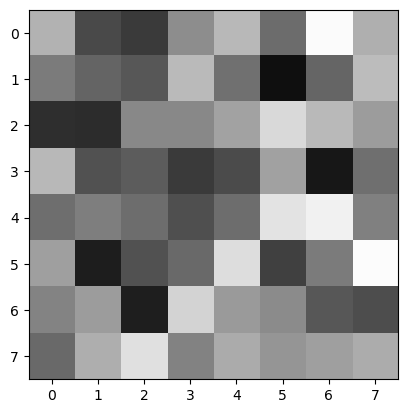

In [3]:
image = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0]
]).astype(float)

np.random.seed(123)
rand_image = np.random.rand(8,8)
image = rand_image

max_intensity = max([val for row in image for val in row])

_ = plt.imshow(image, cmap='gray', vmin=0, vmax=1)

In [4]:
intensities = np.array([[value] for image_row in image for value in image_row])
positions_map = [[] for _ in range(int((len(image)/2)**2))]
avg_intensities = [0 for _ in range(int((len(image)/2)**2))]

kmeans = KMeans(n_clusters=int((len(image)/2)**2), random_state=0).fit(intensities)

for i,val in enumerate(kmeans.labels_):
    avg_intensities[val] += intensities[i][0]
    positions_map[val].append(i)
    
for i in range(len(avg_intensities)):
    if list(kmeans.labels_).count(i) > 0:
        avg_intensities[i] = avg_intensities[i] / list(kmeans.labels_).count(i)

# print(intensities)

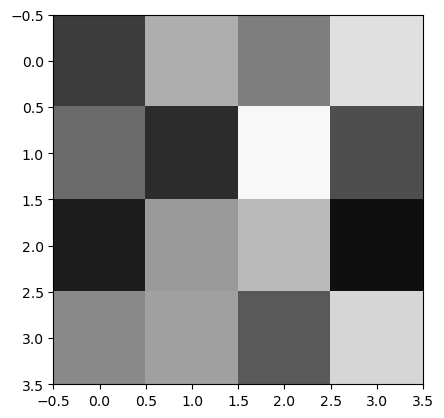

In [5]:
image_4 = np.array(avg_intensities).reshape((4, 4))
_ = plt.imshow(image_4, cmap='gray', vmin=0, vmax=1)

In [6]:
intensities = [i for image_row in image_4 for i in image_row]
sqrt_intensities = [np.sqrt(i) for i in avg_intensities]
scaled_intensities = [i*(1/np.sqrt(sum(avg_intensities))) for i in sqrt_intensities]

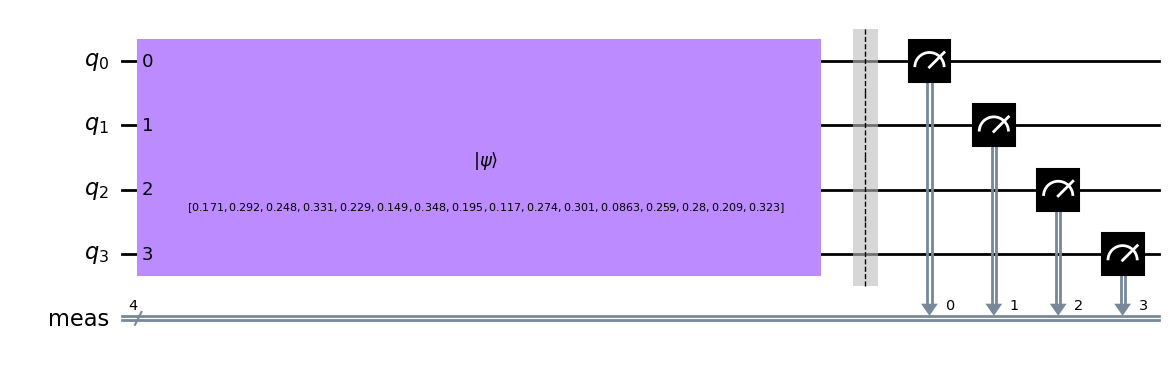

In [7]:
qc = QuantumCircuit(4)

# initialization to match amplitudes
qc.initialize(scaled_intensities)
qc.measure_all()

qc.draw('mpl')

In [8]:
transpiled_circuit = transpile(qc, basis_gates=['cx', 'id', 'rz', 'sx', 'x'], optimization_level=3)
print('Circuit Depth:', transpiled_circuit.depth())
# transpiled_circuit.draw('mpl')

dag = circuit_to_dag(transpiled_circuit)
cxs = dag.op_nodes(CXGate)
for cx in cxs:
    remove = True
    for ancestor in dag.ancestors(cx):
        if isinstance(ancestor, DAGOpNode):
            if ancestor.qargs[0] == cx.qargs[0]:
                remove = False
    if remove:
        dag.remove_op_node(cx)
        
transpiled_circuit = transpile(dag_to_circuit(dag), basis_gates=['rz', 'cx', 'sx'], optimization_level=3)
print('Circuit Depth:', transpiled_circuit.depth())

Circuit Depth: 63
Circuit Depth: 63


{'0000': 972, '1000': 433, '1011': 225, '1111': 3361, '1101': 2530, '1001': 2485, '0101': 764, '0110': 4096, '1100': 2172, '0100': 1711, '1110': 1432, '1010': 3008, '0010': 1990, '0001': 2710, '0011': 3629, '0111': 1250}


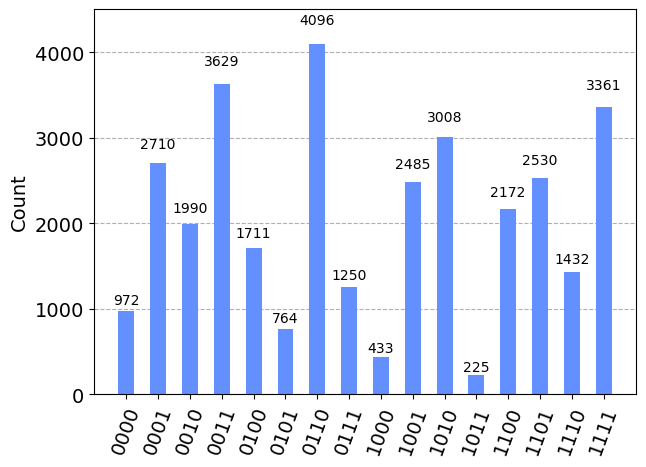

In [9]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
result = aer_sim.run(t_qc, shots=2**15).result()
counts = result.get_counts(qc)

print(counts)
plot_histogram(counts)

In [10]:
# Image reconstruction
highest_count = max(counts.values())
rec_image = [[0 for _ in range(4)] for _ in range(4)]

for k in counts.keys():
    q1 = int(k[:2], 2)
    q2 = int(k[2:], 2)
    
    rec_image[q1][q2] = (counts[k]/highest_count)*max_intensity

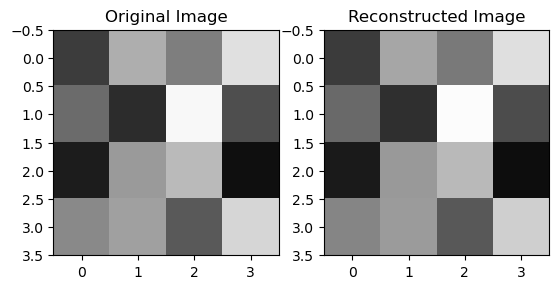

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

_ = ax1.imshow(image_4, cmap='gray', vmin=0, vmax=1)
_ = ax1.set_title('Original Image')

_ = ax2.imshow(rec_image, cmap='gray', vmin=0, vmax=1)
_ = ax2.set_title('Reconstructed Image')

In [12]:
image_diff = image_4 - rec_image
squared_diff = 0
for i in range(len(image_diff)):
    for j in range(len(image_diff[i])):
        squared_diff += image_diff[i][j]**2

print('Squared error:', squared_diff)

Squared error: 0.003008387262739092


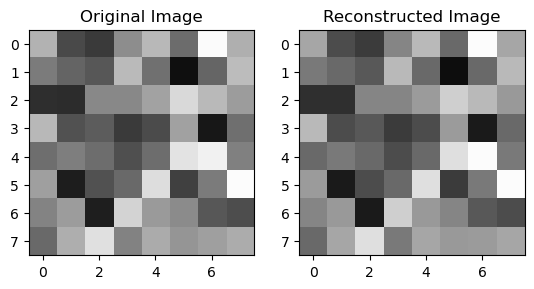

In [13]:
final_rec_image = [[0 for _ in range(len(image))] for _ in range(len(image))]
vec_intensities = [val for row in rec_image for val in row]

for i,val in enumerate(vec_intensities):
    for k in range(len(positions_map[i])):
        pos_x = math.floor(positions_map[i][k]/len(image))
        pos_y = positions_map[i][k]%len(image)
        final_rec_image[pos_x][pos_y] = val

fig, (ax1, ax2) = plt.subplots(ncols=2)

_ = ax1.imshow(image, cmap='gray', vmin=0, vmax=1)
_ = ax1.set_title('Original Image')

_ = ax2.imshow(final_rec_image, cmap='gray', vmin=0, vmax=1)
_ = ax2.set_title('Reconstructed Image')

In [14]:
image_diff = image - final_rec_image
squared_diff = 0
for i in range(len(image_diff)):
    for j in range(len(image_diff[i])):
        squared_diff += image_diff[i][j]**2

print('Squared error:', squared_diff)

Squared error: 0.019814963196114928
